In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

In [4]:
# import autograd.numpy as np
import numpy as np

In [5]:
import tools

In [16]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

# pyforce

In [6]:
import sys
sys.path.append('../research/pyforce/')

In [7]:
from importlib import reload

In [8]:
import pyforce
pyforce = reload(pyforce)

The expression for the stress to optimise is:

$stress(X) = \sum_{i<j}w_{ij}(||X_i - X_j|| - d_{ij})^2$

$w_{ij} = d_{ij}^{-2}$

$||X_i - X_j||$ is a norm computed in the low-dimensional embedding and $d_{ij}$ is the pairwise distance in the high-dimensional embedding.

The gradient for this cost is equal to:

$grad_i(stress(X_i)) = \sum_j 4 w_{ij} \frac{(X_i - X_j)}{||X_i - X_j||} (||X_i - X_j|| - d_{ij})$

An optimisation can take place where gradient descent is for example used.

# MNIST 2k

We start with the small version of the dataset MNIST:

<table>
    <tr>
        <th># of samples</th>
        <th># of classes</th>
        <th>dimensions</th>
    </tr>
    <tr>
        <td>1797</td>
        <td>10</td>
        <td>64</td>
    </tr>
</table>

This dataset is small enough to allow for a simple computation of the forces/gradient without requiring to prune the number of neighbhours taken into consideration.

In [8]:
(X_train, y_train, X_test, y_test) = tools.get_dataset('mnist-2k')

and compute the pairwise distances:

In [9]:
pdist = pyforce.Distances(X_train)

We will look at two different type of initialisation and compute the stress for each initial embeddings:

In [10]:
emb = np.random.random((X_train.shape[0], 2))

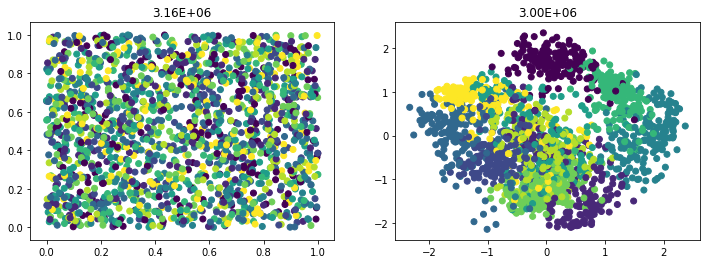

In [11]:
fe_rnd = pyforce.ForceEmbedding(emb, pdist)

from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit_transform(X_train)
from sklearn import preprocessing
pca = preprocessing.scale(pca)
fe_pca = pyforce.ForceEmbedding(pca, pdist)

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].scatter(emb[:,0], emb[:,1], c=y_train)
ax[0].set_title("{:.2E}".format(fe_rnd.stress()))

ax[1].scatter(pca[:,0], pca[:,1], c=y_train)
_=ax[1].set_title("{:.2E}".format(fe_pca.stress()))

We can now optimise the layout for 100 iterations and plot the stress throughout:

In [12]:
%time res = fe_rnd.optimize(n_iter=100)

CPU times: user 1min 27s, sys: 14.3 s, total: 1min 41s
Wall time: 25.6 s


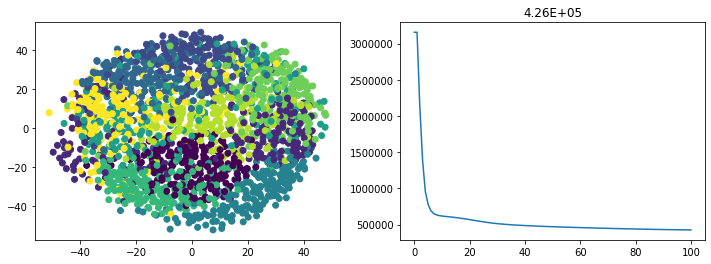

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].scatter(fe_rnd[:,0], fe_rnd[:,1], c=y_train)
ax[1].plot(np.array(fe_rnd.error))
_=ax[1].set_title("{:.2E}".format(fe_rnd.stress()))

In [14]:
%time res = fe_pca.optimize(n_iter=100, method='sgd')

CPU times: user 1min 29s, sys: 14.9 s, total: 1min 44s
Wall time: 26.2 s


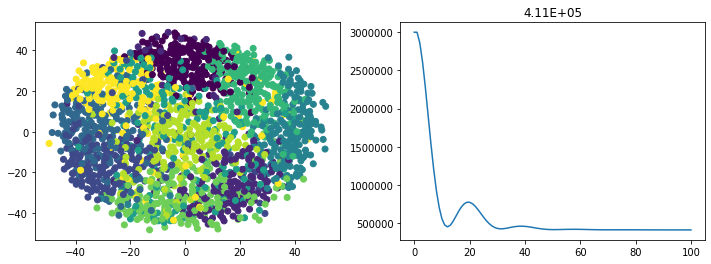

In [15]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].scatter(fe_pca[:,0], fe_pca[:,1], c=y_train)
ax[1].plot(np.array(fe_pca.error))
_=ax[1].set_title("{:.2E}".format(fe_pca.stress()))

# MNIST 70k

We can now look at the bigger version of the MNIST dataset. We have now:

<table>
    <tr>
        <th># of samples</th>
        <th># of classes</th>
        <th>dimensions</th>
    </tr>
    <tr>
        <td>70000</td>
        <td>10</td>
        <td>784</td>
    </tr>
</table>

This is too much data to compute the full pairwise distance in memory. The resulting matrix naively computed would be 70kx70k. We can however take a sample of the data - of size $\sqrt{N}$ for example, use the force layout to compute an embedding on the subset and use interpolation on the rest ($N - \sqrt{N}$ samples).

In [206]:
(X_train, y_train, X_test, y_test) = tools.get_dataset('mnist-70k')

and compute the pairwise distances:

## step 1 - sample $\sqrt{N}$

In [207]:
N = X_train.shape[0]
rootN = np.int(np.sqrt(N))
rootN = np.max((np.int(np.sqrt(N)), 2000))

In [208]:
rootN_ids = np.random.choice(N, size=rootN, replace=False)

In [209]:
rootN_data = X_train[rootN_ids]

In [210]:
pdist = pyforce.Distances(rootN_data)

## step 2 - force-based layout

In [220]:
init = np.random.random((rootN_data.shape[0], 2))

In [219]:
init = PCA(n_components=2).fit_transform(rootN_data)
from sklearn import preprocessing
init = preprocessing.scale(init)

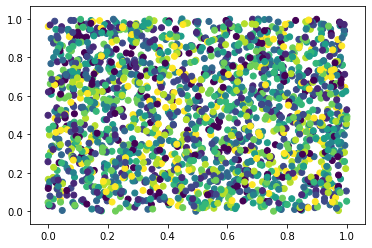

In [221]:
plt.scatter(init[:,0], init[:,1], c=y_train[rootN_ids], rasterized=True)

In [222]:
fe_pca = pyforce.ForceEmbedding(init, pdist)

In [237]:
%time res = fe_pca.optimize(n_iter=1000, method='sgd')

CPU times: user 17min 33s, sys: 2min 56s, total: 20min 30s
Wall time: 5min 30s


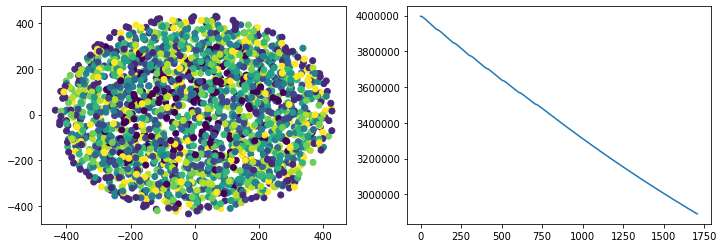

In [238]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].scatter(fe_pca[:,0], fe_pca[:,1], c=y_train[rootN_ids])
ax[1].plot(np.array(fe_pca.error))
# ax[1].set_ylim([0, np.max(fe_pca.error)])

Here, it seems that the optimisation does not manage to improve the layout as rapidly as with MNIST-2K. Instead, we will relax the constraints and set to zero the pairwise distances for all but K neighbhours.

In [61]:
EPSILON = np.finfo(np.float64).eps


# Prune pairwise distances

We follow the paper from Zheng, in which a procedure that only updates the edges is proposed.

Zheng, J. X. S., Pawar, S., & Goodman, D. F. M. (2018). Graph Drawing by Stochastic Gradient Descent. IEEE Transactions on Visualization and Computer Graphics, 1–1. https://doi.org/10.1109/TVCG.2018.2859997

In [194]:
import pyforce
pyforce = reload(pyforce)

Finding the initial K neighbhours takes ~1 minute on MNIST-70k.

In [11]:
ann = pyforce.NNDescent()

In [12]:
%time ann.build(X_train)

/home/antoine/anaconda3/envs/pyforce/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/pyforce/lib/python3.7/site-packages/pynndescent/rp_trees.py", line 133:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/antoine/anaconda3/envs/pyforce/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs

CPU times: user 1min 40s, sys: 3.1 s, total: 1min 43s
Wall time: 28.9 s


In [13]:
K = 3

In [14]:
%time pdist_k3 = ann.query(X_train, K + 1)

/home/antoine/anaconda3/envs/pyforce/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/pyforce/lib/python3.7/site-packages/pynndescent/pynndescent_.py", line 38:
    @numba.njit(parallel=True, fastmath=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  self.func_ir.loc))
/home/antoine/anaconda3/envs/pyforce/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anac

CPU times: user 48.1 s, sys: 739 ms, total: 48.8 s
Wall time: 35.1 s


In [129]:
pca = PCA(n_components=2).fit_transform(X_train)
from sklearn import preprocessing
pca = preprocessing.scale(pca)

In [195]:
fek = pyforce.ForceEmbeddingKEdge(pca.copy(), ann)

In [196]:
fek.set_n_d_K(pdist_k3[0], pdist_k3[1], K)

In [23]:
# %timeit fek.find_K(X_train, 3)

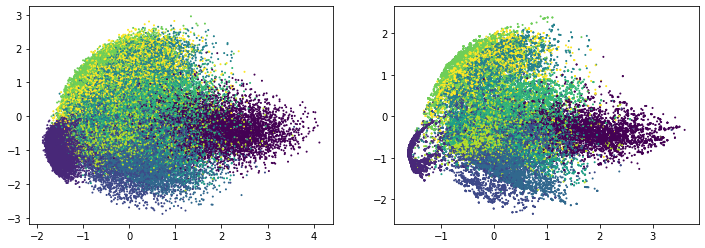

In [163]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].scatter(pca[:,0], pca[:,1], c=y_train, s=1)
ax[1].scatter(fek[:,0], fek[:,1], c=y_train, s=1)

In [162]:
%time fek.optimise(100, 100000)

CPU times: user 12min 22s, sys: 745 ms, total: 12min 23s
Wall time: 12min 22s


In [197]:
(X_train, y_train, X_test, y_test) = tools.get_dataset('mnist-2k')

In [198]:
ann = pyforce.NNDescent()

In [166]:
%time ann.build(X_train)

CPU times: user 1.98 s, sys: 64.2 ms, total: 2.05 s
Wall time: 1.54 s


In [199]:
K = 3

In [168]:
%time pdist_k3 = ann.query(X_train, K + 1)

/home/antoine/anaconda3/envs/pyforce/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/pyforce/lib/python3.7/site-packages/pynndescent/pynndescent_.py", line 38:
    @numba.njit(parallel=True, fastmath=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  self.func_ir.loc))
/home/antoine/anaconda3/envs/pyforce/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anac

CPU times: user 2.42 s, sys: 15.9 ms, total: 2.44 s
Wall time: 2.42 s


In [200]:
init = np.random.random((X_train.shape[0], 2))

In [201]:
fek = pyforce.ForceEmbeddingKEdge(init.copy(), ann)

In [202]:
fek.set_n_d_K(pdist_k3[0], pdist_k3[1], K)

In [203]:
# %timeit fek.find_K(X_train, 3)

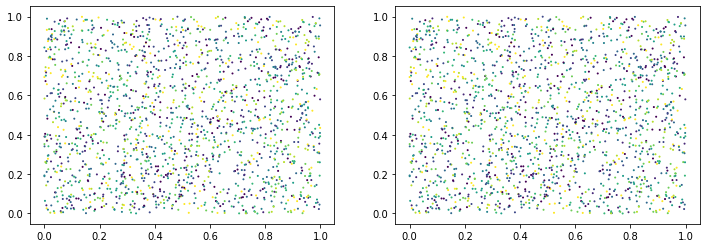

In [204]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].scatter(init[:,0], init[:,1], c=y_train, s=1)
ax[1].scatter(fek[:,0], fek[:,1], c=y_train, s=1)

In [205]:
%time fek.optimise(100, 10000)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Unknown attribute 'compute_grad_edge_i' of type array(float64, 2d, C)

File "../research/pyforce/pyforce.py", line 228:
    def optimise(self, n_iter=100, n_samples=1000):
        <source elided>
            for vertice in updates_ids:
                grad = self.compute_grad_edge_i(vertice)
                ^

[1] During: typing of get attribute at ../research/pyforce/pyforce.py (228)

File "../research/pyforce/pyforce.py", line 228:
    def optimise(self, n_iter=100, n_samples=1000):
        <source elided>
            for vertice in updates_ids:
                grad = self.compute_grad_edge_i(vertice)
                ^

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/latest/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/latest/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


In [241]:
from numba import jit

In [245]:
from numba import njit, prange

In [252]:
class ForceEmbeddingKEdgeNumba(object):

    def __init__(self,
        embedding,
        ann,
        # random_state=None,
        # optimizer=None,
        # negative_gradient_method="fft",
        # **gradient_descent_params,
    ):
        # obj = np.asarray(embedding, dtype=np.float64, order="C").view(ForceEmbeddingKEdge)
        self.X = embedding.copy() 
        
        # add variables
        self.ann = ann


    def set_n_d_K(self, n, d, K):
        self.n = n
        self.d = d[:, 1:]
        self.K = K

        self.d_norm = preprocessing.scale(self.d, with_mean=False)


    def find_K(self, Y, K):
        self.K = K
        self.n, self.d = self.ann.query(Y, K + 1)

        self.d = self.d[:, 1:]

        self.d_norm = preprocessing.scale(self.d, with_mean=False)


    def compute_grad_edge_i(self, seed):
        ld = self.X[self.n[seed]]

        X_ij = ld[0] - ld[1:] + EPSILON
        ld_ij = np.linalg.norm(X_ij, axis=1) + EPSILON

        d_ij = self.d[seed]
        inv_d_ij_2 = 1./(d_ij**2 + EPSILON)

        g = 2 * ((ld_ij - d_ij) / (ld_ij+EPSILON) * inv_d_ij_2)[:, None] * X_ij

        return g

    def update_vertices(self, seed, grad):
        ns = self.n[seed]
        self.X[ns[0]]  += np.sum(grad, axis=0)
        self.X[ns[1:]] -= grad


    @jit(parallel=True)
    def optimise(self, n_iter=100, n_samples=1000):
        # updates_ids = np.random.choice(X_train.shape[0], size=100000, replace=True)

        for i in prange(n_iter):
            updates_ids = np.random.choice(self.shape[0], size=n_samples, replace=True)
            for vertice in updates_ids:
                grad = self.compute_grad_edge_i(vertice)
                self.update_vertices(vertice, grad)



In [253]:
fe_numba = ForceEmbeddingKEdgeNumba(init, ann)

In [254]:
fe_numba.optimise(1, 10)

<ipython-input-252-a6a4ebef68f6>:54: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "optimise" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-252-a6a4ebef68f6> (58)

File "<ipython-input-252-a6a4ebef68f6>", line 58:
    def optimise(self, n_iter=100, n_samples=1000):
        <source elided>

        for i in prange(n_iter):
        ^

  @jit(parallel=True)
<ipython-input-252-a6a4ebef68f6>:54: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "optimise" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "<ipython-input-252-a6a4ebef68f6>", line 58:
    def optimise(self, n_iter=100, n_samples=1000):
        <source elided>

        for i in prange(n_iter):
        ^

  @jit(parallel=True)
/home/antoine/anaconda3/envs/pyforce/lib/python3.7/site-packages/numba/compiler.py:742

AttributeError: 'ForceEmbeddingKEdgeNumba' object has no attribute 'shape'

In [134]:
(pca == fek).all()

ForceEmbeddingKEdge(False)

In [159]:
ids = np.random.choice(X_train.shape[0], size=10, replace=False)

In [160]:
g = fek.compute_grad_edge_i(ids[0])

In [161]:
g

ForceEmbeddingKEdge([[-0.00135037, -0.00070188],
                     [-0.00084401, -0.00102768],
                     [-0.00077375, -0.00104346]])

In [116]:
ids[0]

65372

In [117]:
fek[ids[0]]

ForceEmbeddingKEdge([-0.74062609,  1.43490132])

In [119]:
fek.update_vertices(ids[0], g)

In [120]:
fek[ids[0]]

ForceEmbeddingKEdge([-0.74115132,  1.43301441])

In [82]:
updates_ids = np.random.choice(X_train.shape[0], size=1, replace=False)

In [85]:
updates_ids[0]

49147

In [83]:
g = fek.compute_grad_edge_i(updates_ids[0])

In [84]:
g

ForceEmbeddingKEdge([[ 3.88503688e-04, -1.22523230e-04],
                     [-4.06983068e-05, -3.81691401e-04],
                     [ 1.86314830e-04, -3.14260126e-04]])

In [59]:
ld = fek[fek.n[updates_ids[0]]]

In [64]:
ld

ForceEmbeddingKEdge([[-0.77193971,  1.50297293],
                     [-0.75930281,  1.58714342],
                     [-0.86877044,  1.44110261],
                     [-0.70290116,  1.06433391]])

In [66]:
X_ij = ld[0] - ld[1:] + EPSILON

In [67]:
X_ij

ForceEmbeddingKEdge([[-0.01263689, -0.08417048],
                     [ 0.09683073,  0.06187032],
                     [-0.06903854,  0.43863903]])

In [68]:
ld_ij = np.linalg.norm(X_ij, axis=1) + EPSILON

In [70]:
d_ij = fek.d[updates_ids[0]]

In [71]:
d_ij

array([817.31939901, 818.75209923, 858.25345907])

In [74]:
inv_d_ij_2 = 1./(d_ij**2 + EPSILON)

In [75]:
inv_d_ij_2

array([1.49698134e-06, 1.49174691e-06, 1.35759077e-06])

In [77]:
((ld_ij - d_ij) / (ld_ij+EPSILON) * inv_d_ij_2)[:, None] * X_ij / 2

ForceEmbeddingKEdge([[ 9.08182739e-05,  6.04912749e-04],
                     [-5.14535079e-04, -3.28763906e-04],
                     [ 9.05316270e-05, -5.75196153e-04]])

In [69]:
X_train.shape

(70000, 784)

In [48]:
neighbhours, distances = pdist_k3

In [49]:
neighbhours, distances

(array([[    0, 32248,  8728, 18932],
        [    1,   639, 51121, 67601],
        [    2, 64458, 54197, 46128],
        ...,
        [69997,  3261, 58994, 35362],
        [69998, 66136, 36407,  1311],
        [69999, 22424,  5179,  5329]]),
 array([[   0.        , 1561.47238208, 1591.60139482, 1594.71909752],
        [   0.        , 1020.6473436 , 1100.52941805, 1114.23740738],
        [   0.        , 1358.46567862, 1377.63057457, 1541.12718489],
        ...,
        [   0.        ,  985.55415884, 1042.74349674, 1091.54157044],
        [   0.        , 1099.89090368, 1313.7682444 , 1335.91616503],
        [   0.        , 1014.89457581, 1226.16801459, 1301.65125898]]))

In [175]:
# distances_norm = preprocessing.scale(distances[:, 1:], with_mean=False)

In [240]:
emb = pca.copy()

In [223]:
EPSILON = np.finfo(np.float64).eps

In [238]:
def compute_grad_edge_i(n, d, X):
    ld = X[n]
    X_ij = ld[0] - ld[1:] + EPSILON
    ld_ij = np.linalg.norm(X_ij, axis=1) + EPSILON

    #d_ij = d[1:]
    d_ij = d
    
    g = (ld_ij - d_ij / ld_ij)[:, None] * X_ij / 2 

    return g

In [239]:
def update_vertices(n, grad, X):
    
    X[n[0]]  += 0.1 * np.sum(grad, axis=0)
    X[n[1:]] -= .2 * grad
    
    return X

In [75]:
res_grad = compute_grad_edge_i(neighbhours[0], distances[0], emb)

In [87]:
res_emb = update_vertices(neighbhours[0], res_grad, emb)

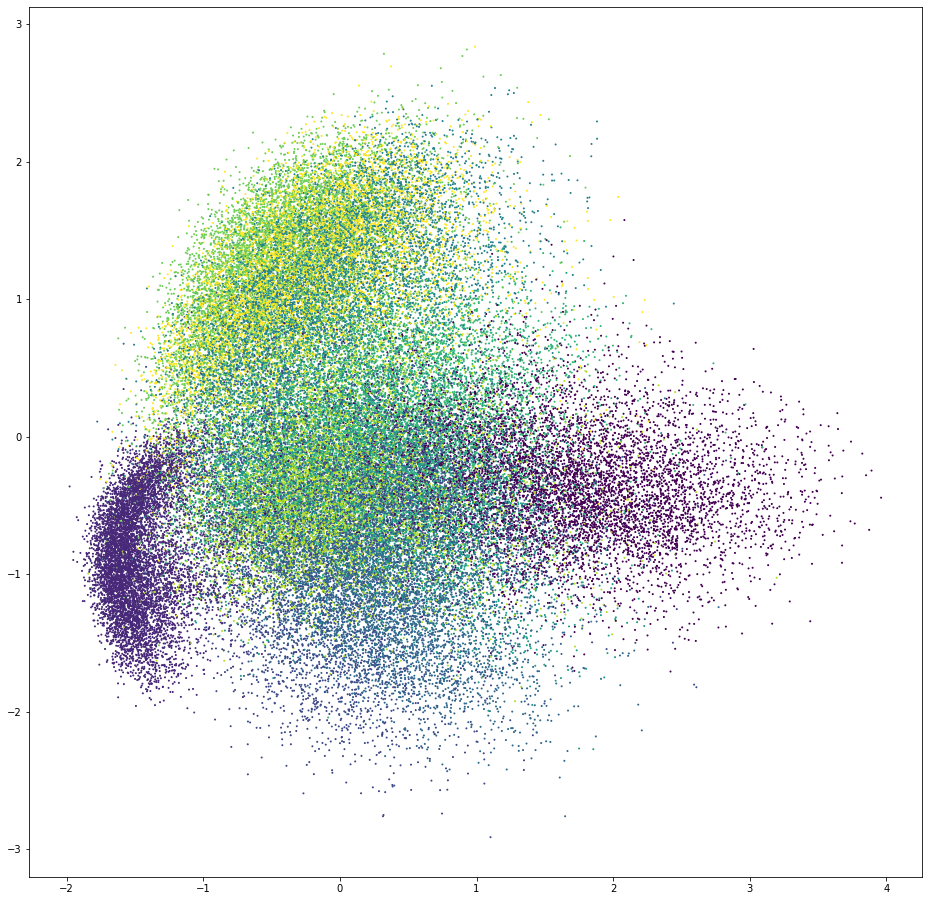

In [197]:
fig, ax = plt.subplots(figsize=(16,16))
ax.scatter(emb[:,0], emb[:,1], c=y_train, s=1)

# for vertices in neighbhours[:1000]:

#     e0 = emb[vertices][0] * np.ones((3,1))
#     e1 = emb[vertices][1:]
    
#     for a,b,c,d in np.hstack([e0, e1]):
#         ax.plot([a,c], [b,d], 'k', alpha=.5)

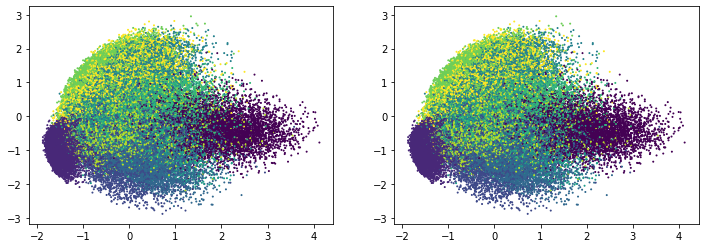

In [241]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].scatter(pca[:,0], pca[:,1], c=y_train, s=1)
ax[1].scatter(emb[:,0], emb[:,1], c=y_train, s=1)


In [243]:
emb

array([[-0.0603161 , -0.72462881],
       [        nan,         nan],
       [ 0.13352077,  1.00179228],
       ...,
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan]])

In [204]:
updates_ids = np.random.choice(X_train.shape[0], size=100000, replace=True)

In [242]:
for i in range(100):
    updates_ids = np.random.choice(X_train.shape[0], size=10000, replace=True)
    for vertice in updates_ids:
        res_grad = compute_grad_edge_i(neighbhours[vertice], distances_norm[vertice], emb)
        res_emb = update_vertices(neighbhours[vertice], res_grad, emb)

/home/antoine/anaconda3/envs/pyforce/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until


In [213]:
res_grad

array([[ 1.8929815 ,  0.21202412],
       [-0.48849892,  2.20859129],
       [-2.22912527, -0.05384644]])

In [178]:
n, d, X = neighbhours[vertice], distances_norm[vertice], emb

In [180]:
ld = X[n]
X_ij = ld[0] - ld[1:]
ld_ij = np.linalg.norm(X_ij, axis=1)
d_ij = d
g = (ld_ij - d_ij / ld_ij)[:, None] * X_ij / 2 


In [181]:
g

array([[-1.90021266, -0.59133439],
       [-1.74983249,  1.17695783],
       [-1.80202425,  1.18227654]])

In [155]:
ld

array([[-2.10374944e+09,  5.80283069e+08],
       [ 1.88705948e+05,  6.99604301e+02],
       [ 1.18917693e+03,  7.37901519e+02],
       [ 4.20751185e+09, -1.16062306e+09]])

(array([8.4030e+03, 1.2584e+04, 1.5263e+04, 4.6380e+04, 6.3921e+04,
        4.3762e+04, 1.5958e+04, 3.3290e+03, 3.7500e+02, 2.5000e+01]),
 array([ 209.54951682,  424.07626294,  638.60300906,  853.12975518,
        1067.6565013 , 1282.18324742, 1496.70999354, 1711.23673966,
        1925.76348579, 2140.29023191, 2354.81697803]),
 <a list of 10 Patch objects>)

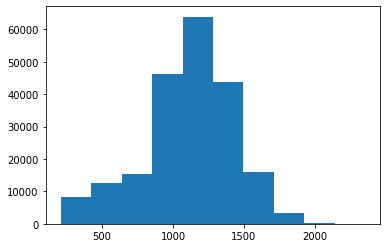

In [171]:
plt.hist(distances[:, 1:].ravel())

(array([8.1300e+03, 1.2556e+04, 1.3723e+04, 4.3855e+04, 6.3233e+04,
        4.6166e+04, 1.7861e+04, 3.9410e+03, 4.9400e+02, 4.1000e+01]),
 array([0.66879236, 1.33780952, 2.00682669, 2.67584385, 3.34486102,
        4.01387818, 4.68289535, 5.35191251, 6.02092968, 6.68994684,
        7.35896401]),
 <a list of 10 Patch objects>)

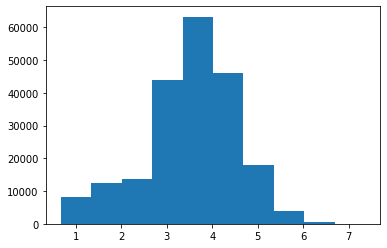

In [174]:
plt.hist(preprocessing.scale(distances[:, 1:], with_mean=False).ravel())

In [ ]:
pdist.shape

In [ ]:
plt.hist(pdist.ravel())

In [ ]:
fe = ForceEmbedding(pca, pdist)

In [ ]:
fe.stress()

In [ ]:
%time res = fe.optimize(1000)

In [ ]:
plt.scatter(res[:,0], res[:,1], c=y_train[rootN_ids], rasterized=True)

In [ ]:
fe_pca.error

In [ ]:
pdist = pyforce.Distances(X_train)

In [ ]:
plt.hist(fe_pca.d_ij.ravel())

In [ ]:
import numpy as np

import scipy.spatial as ss
EPSILON = np.finfo(np.float64).eps


class Distances:

    def __new__(
        self,
        data,
        method='full',
        metric='euclidean',
        # metric_params=None,
        # symmetrize=True,
        # n_jobs=1,dd
        # random_state=None,
    ):
        # compute pairwise distances
        if (method == 'full'):
            pdist = ss.distance.pdist(data, metric)
            distances = ss.distance.squareform(pdist)

        elif method == 'approx':
            # use ANN from pynndescent
            raise NotImplementedError("Method not yet supported. Choice are approx or full.")
        else:
            raise ValueError("Method not supported. Choice are approx or full.")

        return distances

class ForceEmbedding(np.ndarray):

    def __new__(cls,
        embedding,
        pdist,
        # random_state=None,
        # optimizer=None,
        # negative_gradient_method="fft",
        # **gradient_descent_params,
    ):
        obj = np.asarray(embedding, dtype=np.float64, order="C").view(ForceEmbedding)

        # add variables
        obj.d_ij = pdist
        obj.inv_d_ij_2 = 1./(pdist**2 + EPSILON)

        return obj

    def stress(self):
        pdist = ss.distance.pdist(self)
        e_ij_2 = ss.distance.squareform(pdist)
        res = np.sum((e_ij_2 - self.d_ij)**2 * self.inv_d_ij_2)
        return res

    def force(self):
        # d_ij is the distance in high-dimensional space
        # e_ij is the distance in low-dimensional space

        # F_ij = ||Xi-Xj||-d_ij)/||Xi-Xj|| * (Xi-Xj)/d_ij**2
        pdist = ss.distance.pdist(self, 'euclidean')
        e_ij_2 = ss.distance.squareform(pdist)

        # https://stackoverflow.com/questions/32415061/
        a = self[:, None, :]
        e_ij_1 = (a - a.swapaxes(0,1))

        F_ij_2 = (e_ij_2 - self.d_ij) / (e_ij_2 + EPSILON)
        F_ij = F_ij_2[:,:] * self.inv_d_ij_2
        # https://stackoverflow.com/questions/39026173/
        F_ij = F_ij[:,:,None] * e_ij_1

        F_i = np.sum(F_ij, axis=1)
        return F_i

    def optimize(self,
        n_iter,
        learning_rate=200,
        momentum=0.5, exaggeration=None, dof=1, min_gain=0.01,
        min_grad_norm=1e-8, max_grad_norm=None, theta=0.5,
        n_interpolation_points=3, min_num_intervals=50, ints_in_interval=1,
        reference_embedding=None, n_jobs=1,
        use_callbacks=False, callbacks=None, callbacks_every_iters=50
        ):

        update = np.zeros_like(self)
        gains = np.ones_like(self)

        self.error = []
        self.error.append(self.stress())

        for iteration in range(n_iter):

            gradient = self.force()

#             grad_direction_flipped = np.sign(update) != np.sign(gradient)
#             grad_direction_same = np.invert(grad_direction_flipped)
#             gains[grad_direction_flipped] += 0.2
#             gains[grad_direction_same] = gains[grad_direction_same] * 0.8 + min_gain

#             update = momentum * update - learning_rate * gains * gradient

#             self += update
            self -= gradient

            self.error.append(self.stress())

        return self

# random init

In [ ]:
fe = ForceEmbedding(emb, pdist)

In [ ]:
fe.stress()

## PCA init

In [ ]:
emb = np.random.random((X_train.shape[0], 2))

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit_transform(X_train)
plt.scatter(pca[:,0], pca[:,1], c=y_train)

In [ ]:
fe = ForceEmbedding(pca, pdist)

In [ ]:
fe.stress()

In [ ]:
%time res = fe.optimize(100)

# Mnist 70k - root N

In [ ]:
plt.scatter(res[:,0], res[:,1], c=y_train)

## step 1 - sample $\sqrt{N}$

In [ ]:
N = X_train.shape[0]
# rootN = np.int(np.sqrt(N))
rootN = np.max((np.int(np.sqrt(N)), 1000))

In [ ]:
rootN_ids = np.random.choice(N, size=rootN, replace=False)

In [ ]:
rootN_data = X_train[rootN_ids]

## step 2 - force-based layout

In [ ]:
pca = PCA(n_components=2).fit_transform(rootN_data)

In [ ]:
from sklearn import preprocessing
pca = preprocessing.scale(pca)

In [ ]:
plt.scatter(pca[:,0], pca[:,1], c=y_train[rootN_ids], rasterized=True)

In [ ]:
pdist = Distances(rootN_data)

In [ ]:
fe = ForceEmbedding(pca, pdist)

In [ ]:
fe.stress()

In [ ]:
%time res = fe.optimize(1000)

In [ ]:
plt.scatter(res[:,0], res[:,1], c=y_train[rootN_ids], rasterized=True)

In [ ]:
plt.plot(np.array(fe.error))

In [ ]:
fe.force()

In [ ]:
from openTSNE import TSNE

In [ ]:
res_tsne = []
tsne = TSNE(n_jobs=8,
            initialization='pca',
            callbacks=lambda it, err, emb: res_tsne.append((it, err)),
            callbacks_every_iters=1,
           )

In [ ]:
%time embd_tsne = tsne.fit(rootN_data)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(embd_tsne[:,0], embd_tsne[:,1], c=y_train[rootN_ids], rasterized=True)

In [ ]:
fe_tsne = ForceEmbedding(embd_tsne, pdist)

In [ ]:
fe_tsne.stress()

In [ ]:
plt.scatter(fe_tsne[:,0], fe_tsne[:,1], c=y_train[rootN_ids], rasterized=True)

In [ ]:
fe_tsne[:,0].shape

In [ ]:
fe.force()

In [ ]:
plt.hist(res.d_ij.ravel())

In [ ]:
from sklearn import preprocessing
res = preprocessing.scale(fe.d_ij, with_mean=False)

In [ ]:
plt.hist(res.ravel())

In [ ]:
pdist = ss.distance.pdist(self, 'euclidean')
e_ij_2 = ss.distance.squareform(pdist)

# https://stackoverflow.com/questions/32415061/
a = self[:, None, :]
e_ij_1 = (a - a.swapaxes(0,1))


F_ij_2 = (e_ij_2 - self.d_ij) / (e_ij_2 + np.finfo(float).eps)
# https://stackoverflow.com/questions/39026173/
F_ij = F_ij_2[:,:,None] * e_ij_1

F_i = np.sum(F_ij, axis=1)
return F_i

In [ ]:
pdist = ss.distance.pdist(fe, 'euclidean')
e_ij_2 = ss.distance.squareform(pdist)

In [ ]:
e_ij_2

In [ ]:
a = fe[:, None, :]
e_ij_1 = (a - a.swapaxes(0,1))

In [ ]:
e_ij_1

In [ ]:
F_ij_2 = (e_ij_2 - fe.d_ij) / (e_ij_2 + np.finfo(float).eps)

In [ ]:
F_ij_2

In [ ]:
F_ij = F_ij_2[:,:,None] * e_ij_1

In [ ]:
F_ij

In [ ]:
F_i = np.sum(F_ij, axis=1)

In [ ]:
F_i

In [ ]:
A = np.arange(9).reshape((3,3))

In [ ]:
A

In [ ]:
1./(A**2+np.finfo(float).eps)

# compute cost gradient

The expression for the stress to optimise is:

$stress(X) = \sum_{i<j}w_{ij}(||X_i - X_j|| - d_{ij})^2$

with:

$w_{ij} = d_{ij}^{-2}$

The update rule is to take the gradient and substract it.

In [ ]:
import autograd

In [ ]:
from autograd import grad

In [ ]:
def stress(X):
    pdist = ss.distance.pdist(X)
    res = np.sum((pdist - d_ij)**2 / d_ij)
    return res

In [ ]:
grad_stress = grad(stress)

In [ ]:
emb = np.random.random((X_train.shape[0], 2))

In [ ]:
pdist = ss.distance.pdist(emb)

In [ ]:
grad = grad_stress(pdist)

In [ ]:
plt.plot(grad)